# Mode Cleaner design notebook
Calculate the transmission of the mode cleaner (MC), find the ideal parameters of the cavity (Length, Finesse, RoC) and calculate the losses and characteristics of the circulating beam.

The geometric & optical length are defined as in the thesis of Eleonora Polini (p209).

In [1]:
# import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import MC_design_functions as MCdf
import sys
plt.style.use('ggplot')

c = 2.99792e8 # Speed of light
lambda_ = 1064e-9 # Carrier wavelength (m)
idxn = 1.44963 # Index of the cavity
SB_limit = 0.90  # SBs transmissions limit
fm = [6.270777e6, 6.270777e6 * 9]  # List of the SBs frequency

## Pound–Drever–Hall (PDH) technique
Plot a two-mirror Fabry–Perot cavity reflection transfer function and a PDH readout signal.

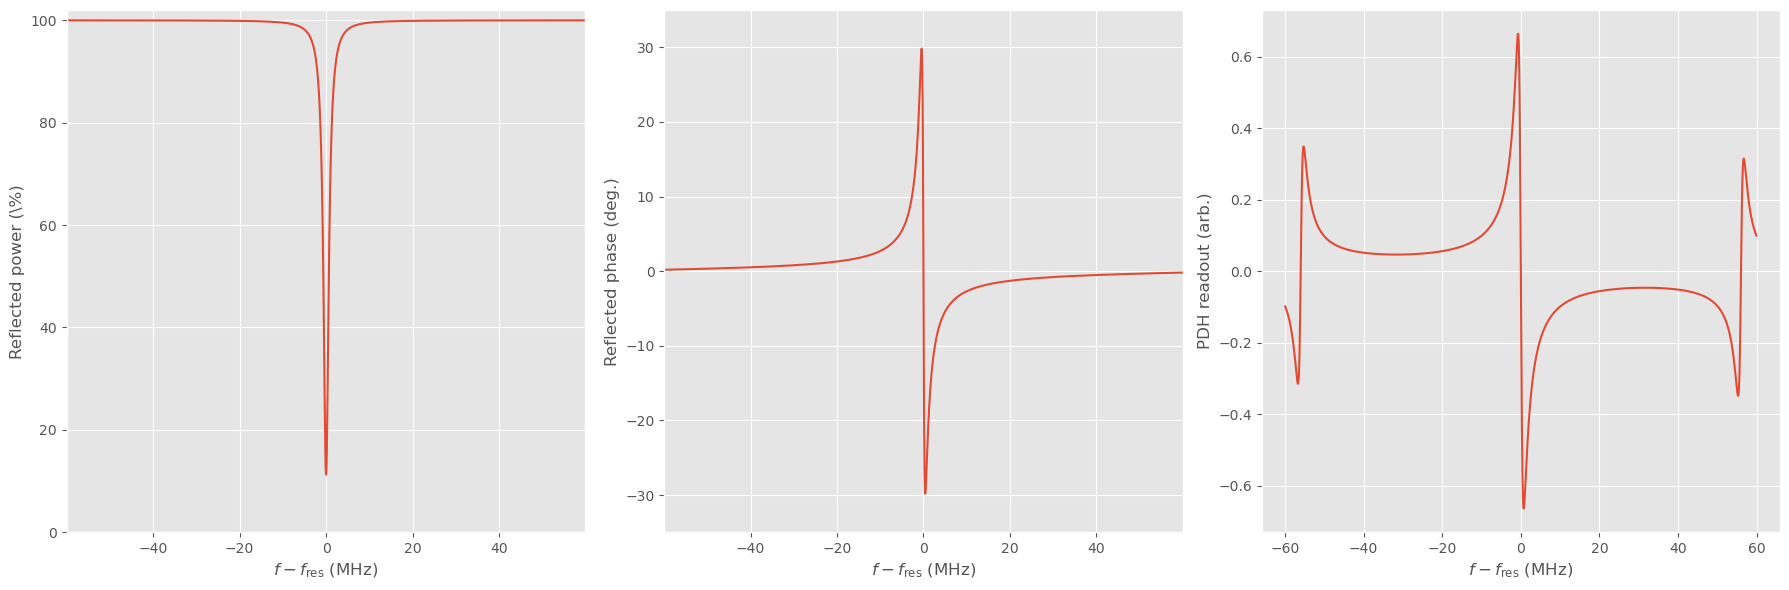

In [2]:
# Call the function with the desired parameters
L = 1.  # length of the optical cavity
r1 = .99  # input mirror reflectivity
r2 = .98  # end mirror reflectivity

f, R, pdh, fsr = MCdf.PDH(L, 56e6,r1,r2)

# Set up subplots and plot the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Reflected power
axes[0].plot(f/1e6, 100*np.abs(R)**2)
axes[0].axis([-.4*fsr/1e6, .4*fsr/1e6, 0, 102])
axes[0].set_ylabel('Reflected power (\%)')
axes[0].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot Reflected phase
axes[1].plot(f/1e6, 180*np.angle(R)/np.pi)
axes[1].axis([-.4*fsr/1e6, .4*fsr/1e6, -35, 35])
axes[1].set_ylabel('Reflected phase (deg.)')
axes[1].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot PDH readout
axes[2].plot(f/1e6, np.imag(pdh))
axes[2].set_ylabel('PDH readout (arb.)')
axes[2].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

plt.tight_layout()  # Adjust the layout to avoid overlapping
plt.show()

**Correspond well to the PDH signals.**

## Transmission of a Mode Cleaner cavity

Determine the parameters intervals (cf VIR-NOT-071A-08).

In [3]:
# Constants
f = c / lambda_ # Carrier frequency (Hz)
R1 = 0.99; T1=np.sqrt(1-R1) # mirror 1
R2 = 0.99; T2=np.sqrt(1-R2) # mirror 2
TEM_limit = 0.01 # Sidebands & HOMs transmissions limits
Lopt_lim, F_lim, RoC_lim = [10e-3, 30e-2], [5, 500], [0,0] # Parameters limits
nm_max = 10 # Number of HOMs to consider
FLopt_lim=[0,0]; RLgeo_lim=[0,0]
k=2*np.pi*f/c

print("-----Parameters intervals-----")
# Losses limitations
losses_max=1/100; P=30/1000000 # P being the loss per face
if np.pi*losses_max/(4*P)<F_lim[1]: F_lim[1]=np.pi*losses_max/(4*P)
print(round(F_lim[0],4),"<F<",round(F_lim[1],4))

# Sidebands transmission
FLopt_lim[1]=np.sqrt(((1-SB_limit)*c**2)/(16*SB_limit*fm[1]**2))
Lopt_lim[1]=FLopt_lim[1]/F_lim[0]
print(round(Lopt_lim[0]*1e2,4),"<Lopt (cm)<",round(Lopt_lim[1]*1e2,4)) # Lopt being the optical length of a one way trip

# Filtering of higher modes
RLgeo_lim[1]=TEM_limit*(2*FLopt_lim[1]/(idxn*np.pi))**2
RoC_lim[0]=RLgeo_lim[1]/(0.5*Lopt_lim[1]/idxn); RoC_lim[1]=RLgeo_lim[1]/(0.5*Lopt_lim[0]/idxn) # Since Lopt=2*Lgeo*n
print(round(RoC_lim[0]*1e2,4),"<RoC (cm)<",round(RoC_lim[1]*1e2,4))

-----Parameters intervals-----
5 <F< 261.7994
1.0 <Lopt (cm)< 8.8533
1.2376 <RoC (cm)< 10.9568


**The length & RoC needs to be smaller than the one used in the OMC (RoC of 780mm, from VIR-0319A-12).**

Loop on the parameters to find the best ones (i.e. the ones giving the minimal HOMs transmissions).

In [4]:
precisions=[1e-1, 1e-3, 1e-3] # Precisions on F, Lopt (m), and r (m)
T=[[],[]]; Tbefore=[[1]*len(fm),[1]*nm_max]

for F in np.arange(F_lim[0],F_lim[1],precisions[0]): # Scan on the finesse
  FLopt_max=(c*np.sqrt(1-SB_limit))/(4*fm[-1]*np.sqrt(SB_limit)) # Making sure that we respect the condition on FL
  Lopt_max=min(FLopt_max/F, Lopt_lim[1])
    
  for Lopt in np.arange(Lopt_lim[0], Lopt_max, precisions[1]): # Scan on the length
    Lgeo=(0.5*Lopt*idxn)
    RLgeo_max=TEM_limit*(2*F*Lopt/(idxn*np.pi))**2 # Making sure that we respect the condition on RoCL
    RoC_max = min(RLgeo_max / Lgeo, RoC_lim[1])
    
    for RoC in np.arange(max(RoC_lim[0],Lgeo), RoC_max, precisions[2]): # Scan on the RoC
        for i in range(len(fm)):
            T[0].append(MCdf.Trans_factor(Lgeo, F, RoC, fm[i], 0)) # Transmissions of SB
        for i in range(1,nm_max+1):
            T[1].append(MCdf.Trans_factor(Lgeo, F, RoC, 0, i)) # Transmissions of TEM modes
        if T[0][-1]>=TEM_limit:
          if sum(T[1])<sum(Tbefore[1]):
            Parameters=[F,Lopt,RoC] # if the parameters respects the conditions & allow a lower transmissions of the HOMs we keep them
            Tparameters=T
            Tbefore=T
        T=[[],[]]

print("-----Parameters-----")
print("Geometric length (cm)=", 0.5*Parameters[1]*1e2*idxn)
print("Finesse=", Parameters[0])
print("RoC (m)=",Parameters[2])

c:\Users\amy\My Drive\Documents\Études\Université\Master 2\Stage\Virgo_AMC_design\MC_design_functions.py:15: RuntimeWarning: invalid value encountered in sqrt
  T=1/(1+(2*Fomc/np.pi)**2*np.sin((2*np.pi*Lopt*freq/c)-N*np.arccos(np.sqrt(1-(2*Lgeo/RoC))))**2)


-----Parameters-----
Geometric length (cm)= 0.724815
Finesse= 44.19999999999986
RoC (m)= 0.0253759345806586


**The optimal length in this case is always the smaller one.**

We also need to fix a length compatible with the resonnant conditions of the carrier. Then calculate the transmissions of the SBs & HOMs and plot them.

-----Parameters-----
Resonnant geometric length (cm)= 0.7248029305904254

-----Transmissions-----
SBs transmissions: [0.9939970413421071, 0.6715570947704748]
HOMs transmissions: [1.0, 0.0022060137100386647, 0.0012874961013737848, 0.004306175988655244, 0.015622498815118771, 0.0015233926026605438, 0.0015248569704192456, 0.015733283507797905, 0.004292150351584015, 0.0012871075930217311, 0.0022100391554952486]
df (MHz)= 2690.3399743522245


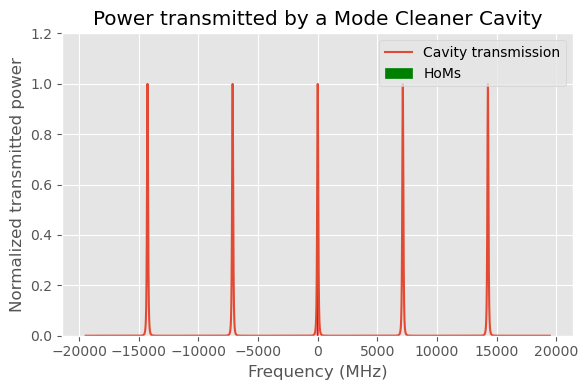

In [5]:
# Find resonnant length for the carrier transmission
g = 1-((0.5*idxn*Parameters[1])/Parameters[2]) # g=1-L/RoC
Parameters[1] = MCdf.get_lengths(Parameters[1], lambda_, g)
Lgeo=(0.5*Parameters[1]*idxn)
g = 1-((0.5*idxn*Parameters[1])/Parameters[2])

print("-----Parameters-----")
print("Resonnant geometric length (cm)=", Lgeo*1e2)
print()

# Transmissions
T = [MCdf.Trans_factor(Lgeo, Parameters[0], Parameters[2], freq, 0) for freq in fm] # of the SBs
TEM = [MCdf.Trans_factor(Lgeo, Parameters[0], Parameters[2], 0, N) for N in range(nm_max + 1)] # of the HOMs
df = np.arccos(np.sqrt(g)) * c / (2 * np.pi * Parameters[1]) # frequency difference between HOMs (due to the Gouy phase)

print("-----Transmissions-----")
print("SBs transmissions:",T)
print("HOMs transmissions:",TEM)
print("df (MHz)=", df/1e6)

# Plotting
plt.figure(figsize=(6, 4))
MCdf.plot_transmission(Lgeo, Parameters[0], Parameters[2], fm, nm_max, plt.gca()) # Calculate the transmissions etc & plot the output of the MC
plt.tight_layout()
plt.show()


**These parameters seems to follow the conditions we imposed on the transmissions. But the length of the cavity is too small to be feasable, and we also need to take into account the HoMs of the SBs.**

## HOMs transmissions with the RoC
Also now taking into account the HOMs of the SBs. The sum of the transmissions of the HOMs correspond to the FoM (Factor of Merit).

Geometric length (cm)= 6.2
Finesse= 2.4626124678399632
Ideal RoC (cm)= 188.61864000000003


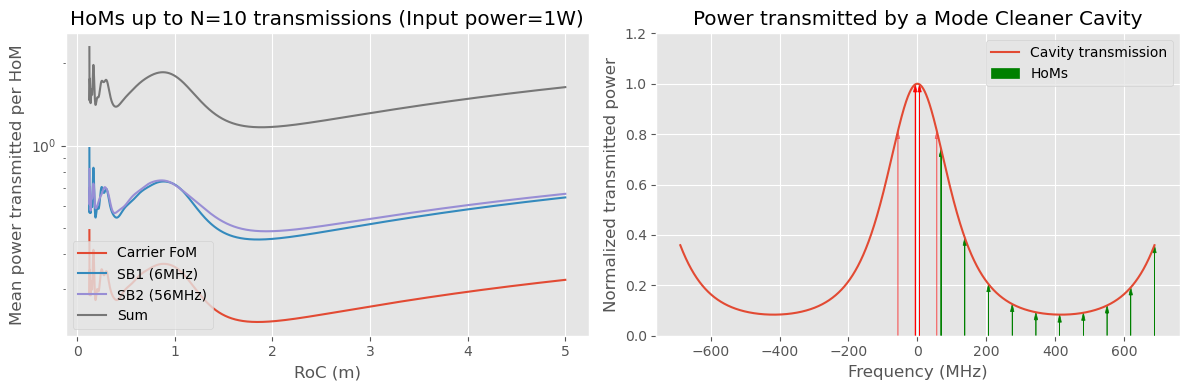

In [6]:
# Input parameters
Lgeo = 0.06200 # Physical length of the cavity (from Marine Ducrot PhD), with approx that hypothenuse=base
Lopt = 2 * idxn * Lgeo # Optical length travelled by the beam in the cavity for a one way trip
P_HoMs=[np.ones(10),np.full(10, 2),np.full(10, 2)] # Input power of carrier & SBs HOMs
RoC_max=5

# Determine the max finesse that respect SB_limit
FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
Fomc = FLopt_max / Lopt

rho_vect, FoM_vect_car, FoM_vect_SB = MCdf.FoMvsRoC(Lgeo, Fomc, RoC_max, fm, P_HoMs) # FoMs calculations
FoM_vect_sum = FoM_vect_car + FoM_vect_SB[0] + FoM_vect_SB[1] # Total power transmitted
Ideal_RoC=rho_vect[np.argmin(FoM_vect_sum)] # Ideal RoC

# Print the parameters choosed
print("Geometric length (cm)=", Lgeo * 10**2)
print("Finesse=", Fomc)
print("Ideal RoC (cm)=", Ideal_RoC*1e2)


# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(rho_vect, FoM_vect_car, label='Carrier FoM')
ax1.plot(rho_vect, FoM_vect_SB[0], label='SB1 (6MHz)')
ax1.plot(rho_vect, FoM_vect_SB[1], label='SB2 (56MHz)')
ax1.plot(rho_vect, FoM_vect_sum, label='Sum')
ax1.set_xlabel('RoC (m)')
ax1.set_ylabel('Mean power transmitted per HoM')
ax1.set_yscale('log')
ax1.set_title('HoMs up to N=10 transmissions (Input power=1W)')
ax1.legend()

MCdf.plot_transmission(Lgeo, Fomc, Ideal_RoC, fm, 10, ax2)

plt.tight_layout()
plt.show()


**We can see that the length used with the OMC is not optimal to our case.**

We can also compute the waist & max intensity (supposing an input of 1W).

In [7]:
waist = MCdf.waist_size(Lgeo, Ideal_RoC, lambda_)
print("Waist size (μm):", waist*1e6)

P_input = 1.0  # Input power in Watts
max_pwr = MCdf.circ_power(P_input, waist)
print("Circ power (MW/m²):", max_pwr/1e6)

Waist size (μm): 1038.2108156082188
Circ power (MW/m²): 0.9277455978555177


**OMC length gives a waist of around 1cm and an intensity of 927kW/m².**

We choose to plot the FoMs for lengths that are fractions of the one of the OMC.

Geometric length (cm) (divisor=2):  3.1
Finesse:  4.9252249356799265
Ideal RoC (m):  0.8
Waist size (μm): 702.310528534627
Circ power (MW/m²): 2.027410268565764

Geometric length (cm) (divisor=4):  1.55
Finesse:  9.850449871359853
Ideal RoC (m):  0.3707383000000001
Waist size (μm): 486.45617099063776
Circ power (MW/m²): 4.225835292989446

Geometric length (cm) (divisor=6):  1.0333333333333332
Finesse:  14.77567480703978
Ideal RoC (m):  0.24349346666666666
Waist size (μm): 395.57299074298425
Circ power (MW/m²): 6.390675094785794

Geometric length (cm) (divisor=8):  0.775
Finesse:  19.700899742719706
Ideal RoC (m):  0.18173450000000002
Waist size (μm): 342.12151078560953
Circ power (MW/m²): 8.54356715856254



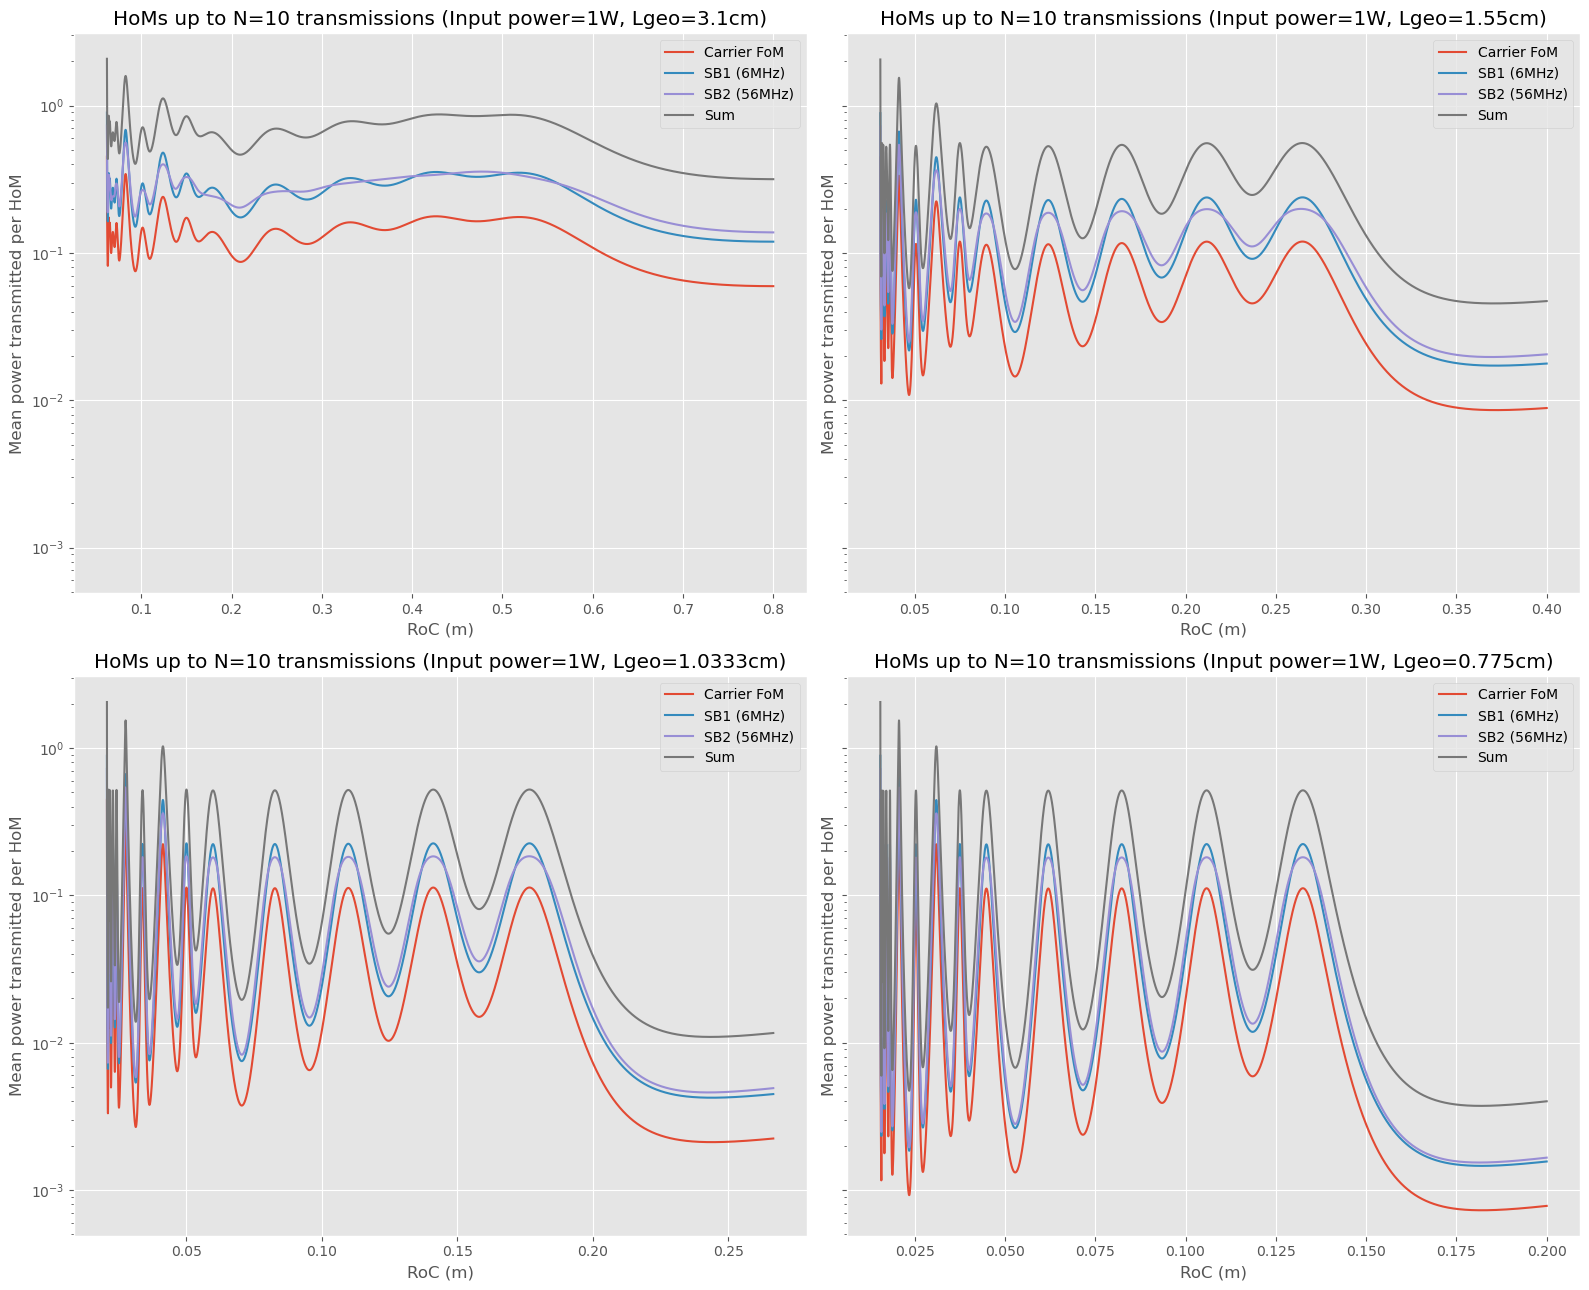

In [8]:
# Input parameters
length_divisors = [2, 4, 6, 8]
P_HoMs = [np.ones(10), np.full(10, 2), np.full(10, 2)]  # Input power of carrier & SBs HOMs

fig, axes = plt.subplots(2, 2, figsize=(16, 13), sharex=False, sharey=True)
axes = axes.flatten()

for i, divisor in enumerate(length_divisors):
    Lgeo = 0.06200 / divisor  # Physical length of the cavity
    Lopt = 2 * idxn * Lgeo  # Optical length travelled by the beam in the cavity

    # Determine the max finesse that respect SB_limit
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Fomc = FLopt_max / Lopt

    # Call the function with the input parameters
    RoC_max=1.6/divisor
    rho_vect, FoM_vect_car, FoM_vect_SB = MCdf.FoMvsRoC(Lgeo, Fomc, RoC_max, fm, P_HoMs)

    # Calculate  the total transmissions of the HOMs & the ideal RoC
    FoM_vect_sum = FoM_vect_car + FoM_vect_SB[0] + FoM_vect_SB[1]
    r = rho_vect[np.argmin(FoM_vect_sum)]

    # Print the parameters choosed
    print(f"Geometric length (cm) (divisor={divisor}): ", Lgeo * 10 ** 2)
    print("Finesse: ", Fomc)
    print("Ideal RoC (m): ", r)
    waist = MCdf.waist_size(Lgeo, r, lambda_)
    print("Waist size (μm):", waist*1e6)
    P_input = 1.0  # Input power in Watts
    max_pwr = MCdf.circ_power(P_input, waist)
    print("Circ power (MW/m²):", max_pwr/1e6)
    print()

    g = (1 - Lgeo / r)

    ax = axes[i]
    ax.plot(rho_vect, FoM_vect_car, label='Carrier FoM')
    ax.plot(rho_vect, FoM_vect_SB[0], label='SB1 (6MHz)')
    ax.plot(rho_vect, FoM_vect_SB[1], label='SB2 (56MHz)')
    ax.plot(rho_vect, FoM_vect_sum, label='Sum')
    ax.set_xlabel('RoC (m)')
    ax.set_ylabel('Mean power transmitted per HoM')
    ax.set_yscale('log')
    ax.set_title(f'HoMs up to N=10 transmissions (Input power=1W, Lgeo={round((Lgeo)*1e2,4)}cm)')
    ax.legend()

plt.tight_layout()
plt.show()


**The best RoC seems to be the one after the oscillations of the FoM, due to the HoMs.**

With more HoMs we should get a different answer.

Geometric length (cm) (divisor=2):  3.1
Finesse:  4.9252249356799265
Ideal RoC (cm):  175.0
Waist size (μm): 863.6906124189936
Circ power (MW/m²): 1.3405518044566973

Geometric length (cm) (divisor=4):  1.55
Finesse:  9.850449871359853
Ideal RoC (cm):  87.5
Waist size (μm): 610.7214888886325
Circ power (MW/m²): 2.6811036089133946

Geometric length (cm) (divisor=6):  1.0333333333333332
Finesse:  14.77567480703978
Ideal RoC (cm):  58.333333333333336
Waist size (μm): 498.6520075766586
Circ power (MW/m²): 4.021655413370094

Geometric length (cm) (divisor=8):  0.775
Finesse:  19.700899742719706
Ideal RoC (cm):  43.75
Waist size (μm): 431.8453062094968
Circ power (MW/m²): 5.362207217826789



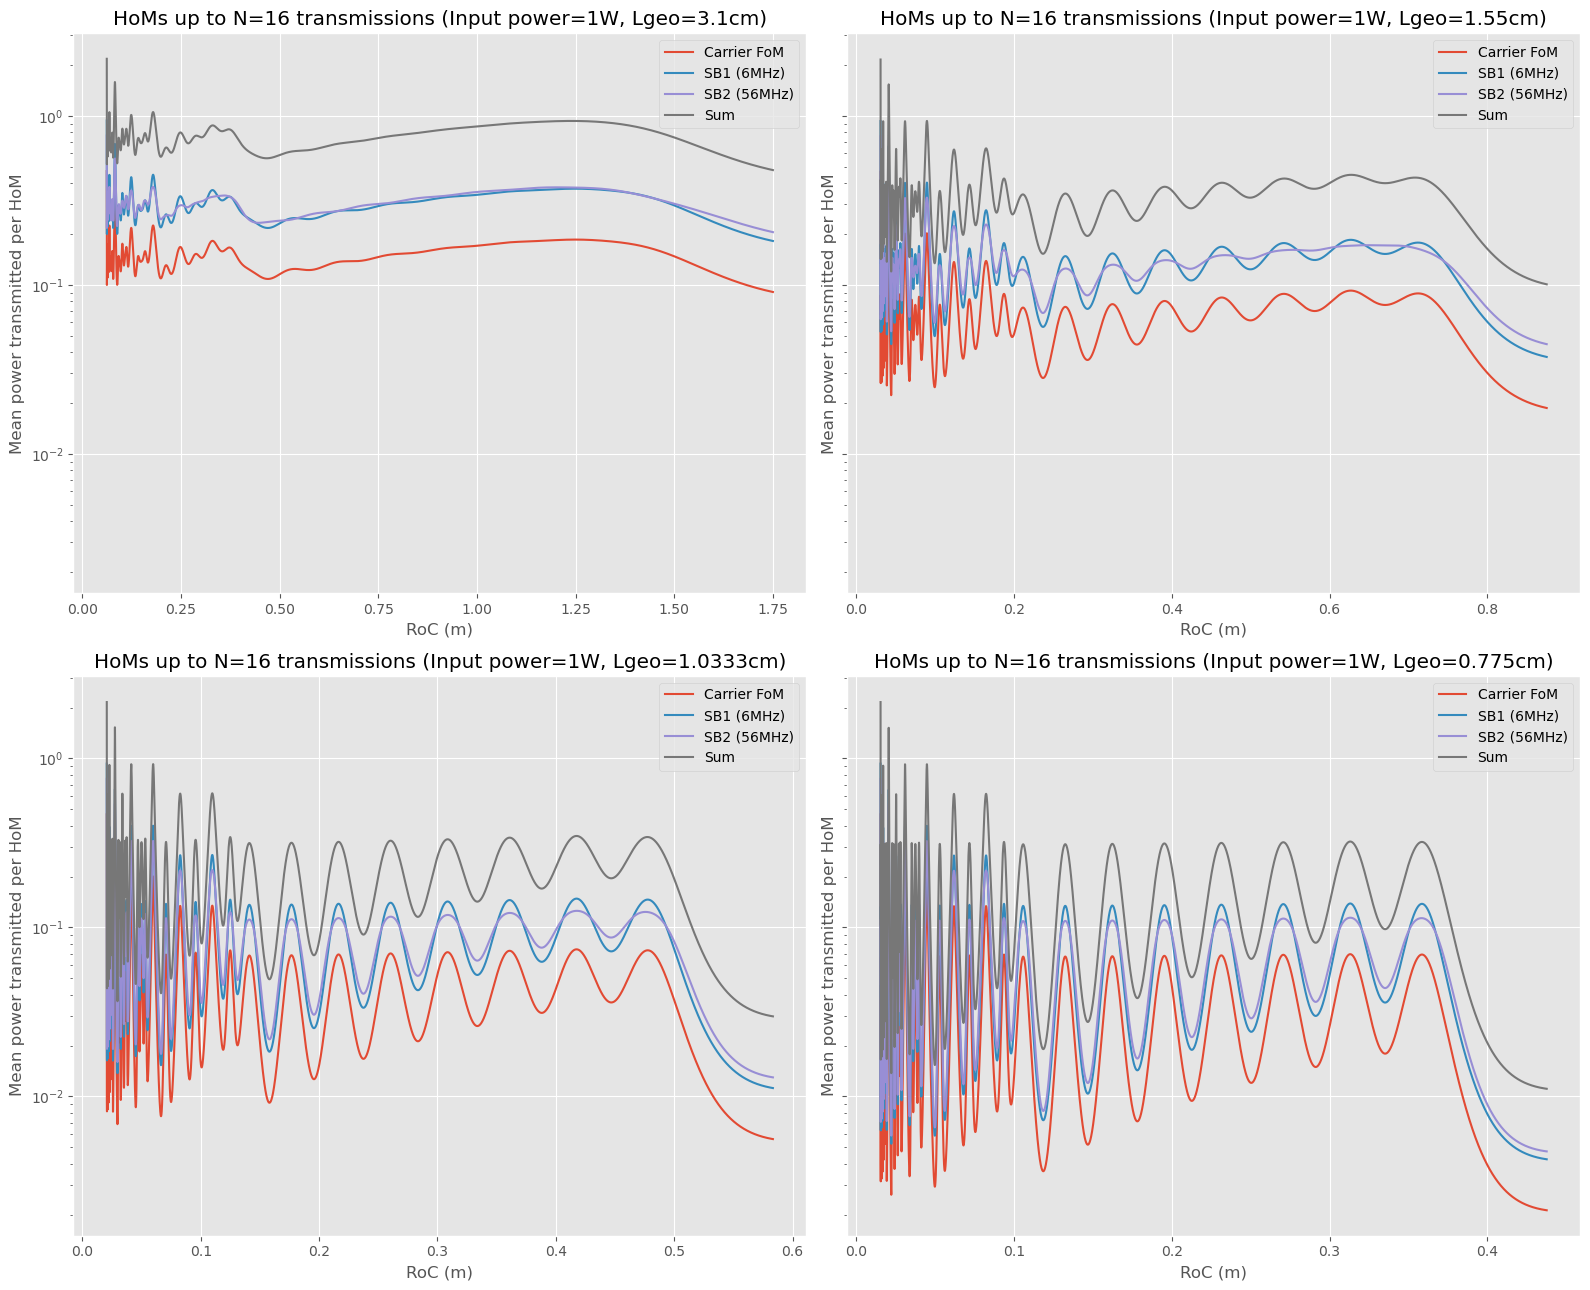

In [9]:
# Input parameters
length_divisors = [2, 4, 6, 8]
P_HoMs = [np.ones(16), np.full(16, 2), np.full(16, 2)]  # Input power of carrier & SBs HOMs

fig, axes = plt.subplots(2, 2, figsize=(16, 13), sharex=False, sharey=True)
axes = axes.flatten()

for i, divisor in enumerate(length_divisors):
    Lgeo = 0.06200 / divisor  # Physical length of the cavity
    Lopt = 2 * idxn * Lgeo  # Optical length travelled by the beam in the cavity

    # Determine the max finesse that respect SB_limit
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
    Fomc = FLopt_max / Lopt

    # Call the function with the input parameters
    RoC_max=3.5/divisor
    rho_vect, FoM_vect_car, FoM_vect_SB = MCdf.FoMvsRoC(Lgeo, Fomc, RoC_max, fm, P_HoMs)

    # Calculate  the total transmissions of the HOMs & the ideal RoC
    FoM_vect_sum = FoM_vect_car + FoM_vect_SB[0] + FoM_vect_SB[1]
    r = rho_vect[np.argmin(FoM_vect_sum)]

    # Print the parameters choosed
    print(f"Geometric length (cm) (divisor={divisor}): ", Lgeo * 10 ** 2)
    print("Finesse: ", Fomc)
    print("Ideal RoC (cm): ", r* 10 ** 2)
    waist = MCdf.waist_size(Lgeo, r, lambda_)
    print("Waist size (μm):", waist*1e6)
    P_input = 1.0  # Input power in Watts
    max_pwr = MCdf.circ_power(P_input, waist)
    print("Circ power (MW/m²):", max_pwr/1e6)
    print()

    g = (1 - Lgeo / r)

    ax = axes[i]
    ax.plot(rho_vect, FoM_vect_car, label='Carrier FoM')
    ax.plot(rho_vect, FoM_vect_SB[0], label='SB1 (6MHz)')
    ax.plot(rho_vect, FoM_vect_SB[1], label='SB2 (56MHz)')
    ax.plot(rho_vect, FoM_vect_sum, label='Sum')
    ax.set_xlabel('RoC (m)')
    ax.set_ylabel('Mean power transmitted per HoM')
    ax.set_yscale('log')
    ax.set_title(f'HoMs up to N=16 transmissions (Input power=1W, Lgeo={round((Lgeo)*1e2,4)}cm)')
    ax.legend()

plt.tight_layout()
plt.show()


**We need to take the input power of each HoMs to choose the best RoC, and the astigmatism losses to choose the AoI (angle of incidence).**

## Losses in the cavity

First estimation of the astigmatism losses of the cavity as a function of the angle of the mirrors theta. The parameters specified are the ones of the OMC (VIR-0319A-12).

c:\Users\amy\My Drive\Documents\Études\Université\Master 2\Stage\Virgo_AMC_design\MC_design_functions.py:38: RuntimeWarning: invalid value encountered in sqrt
  interface_losses=(np.sqrt((1-np.sin(theta)**2)/(1-idxn**2*np.sin(theta)**2))-1)**2


48.32284815462831


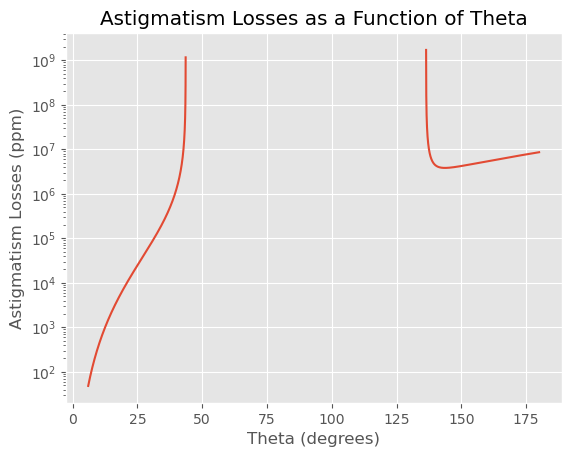

In [10]:
# Define the parameters for the plot
RoC = 780e-3
Lgeo = 0.06200
Lopt=2*idxn*Lgeo
theta_min = np.deg2rad(6)
theta_max = np.pi
num_points = 10000

# Create an array of angles (theta) in radians
theta_values = np.linspace(theta_min, theta_max, num_points)

# Calculate astigmatism_losses for each theta value and convert to ppm
astigmatism_losses_values = [MCdf.astigmatism_losses(theta, RoC, Lgeo) * 1e6 for theta in theta_values]

print(MCdf.astigmatism_losses(np.deg2rad(6), RoC, Lgeo)*1e6)

# Plot the results
plt.plot(np.rad2deg(theta_values), astigmatism_losses_values)
plt.xlabel("Theta (degrees)")
plt.ylabel("Astigmatism Losses (ppm)")
plt.yscale('log')
plt.title("Astigmatism Losses as a Function of Theta")
plt.show()

**The formula used is a valid approximation for small angles. With an angle of 6° we get 48ppm, which is the losses for the OMC (VIR-0319A-12).**

We need to specify a minimum feasable width of the cavity (15mm), then calculate the real geometric length (since the approx hypotenuse=base is no longer true), and then the AoI with the losses.

In [11]:
# Constants
cavity_dim=[[0.06200/2, 0.06200/4, 0.06200/6, 0.06200/8],[15e-3]] # Fixed lengths & width of the cavity
Lgeo=[]; Fomc=[]; Ideal_RoC=[]; Mirror_angle=[]
FoM=[]; astigmatism_losses=[]
P_HoMs = [np.ones(16), np.full(16, 2), np.full(16, 2)]  # Input power of carrier & SBs HOMs

for i in range (len(cavity_dim[0])):
    Lgeo.append(MCdf.Lgeo_cavity(cavity_dim[0][i], cavity_dim[1][0])) # Compute the geometric length of the cavity
    Mirror_angle.append(MCdf.mirror_angle(cavity_dim[0][i], cavity_dim[1][0])) # Compute the mirrors angle in radian
    
    Lopt = 2 * idxn * Lgeo[-1]
    FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit)) # Determine the max finesse that respect SB_limit
    Fomc.append(FLopt_max / Lopt)
    
    rho_vect, FoM_vect_car, FoM_vect_SB = MCdf.FoMvsRoC(Lgeo[-1], Fomc[-1], 3.5, fm, P_HoMs) # Compute the best RoC
    FoM_vect_sum = FoM_vect_car + FoM_vect_SB[0] + FoM_vect_SB[1]
    Ideal_RoC.append(rho_vect[np.argmin(FoM_vect_sum)])
    FoM.append(np.min(FoM_vect_sum)) # Save the FoM
    
    astigmatism_losses.append(MCdf.astigmatism_losses(Mirror_angle[-1], Ideal_RoC[-1], Lgeo[-1]) * 1e6) # Calculate astigmatism losses
    print("Cavity length (cm)=", cavity_dim[0][i]*1e2)
    print("Finesse=", Fomc[-1])
    print("RoC (cm)=", Ideal_RoC[-1]*1e2, ", FoM=", FoM[-1])
    print("Mirror angle (°)=", np.rad2deg(Mirror_angle[-1]), ", losses (ppm)=", astigmatism_losses[-1])
    print()

Cavity length (cm)= 3.1
Finesse= 4.855188306556927
RoC (cm)= 215.81539569211245 , FoM= 0.4173423130293983
Mirror angle (°)= 6.800271258329371 , losses (ppm)= 75.95307913441171

Cavity length (cm)= 1.55
Finesse= 9.3328741532626
RoC (cm)= 99.93970692679895 , FoM= 0.10867375325599979
Mirror angle (°)= 12.91049598709464 , losses (ppm)= 1087.6486576043726

Cavity length (cm)= 1.0333333333333332
Finesse= 13.218322066162177
RoC (cm)= 68.37122688516592 , FoM= 0.04111367272744317
Mirror angle (°)= 17.986193524642456 , losses (ppm)= 4700.605189963397

Cavity length (cm)= 0.775
Finesse= 16.475143846026914
RoC (cm)= 54.24953357956498 , FoM= 0.02022220647974437
Mirror angle (°)= 22.03040452713221 , losses (ppm)= 12394.489673936345



**The best compromise seems to be 1.55cm.** 

We should investigate more on this design, notably by taking a RoC around 10cm.

## Studies with a 1.55cm cavity

Taking a RoC around 10cm.

Cavity length (cm)= 1.55
Finesse= 9.3328741532626
RoC (cm)= 11.140926622748209 , FoM= 0.09175574150622567
Mirror angle (°)= 12.91049598709464 , losses (ppm)= 1238.4037018524457

Waist size (μm): 342.0564351756006
Circ power (MW/m²): 8.54681826378495


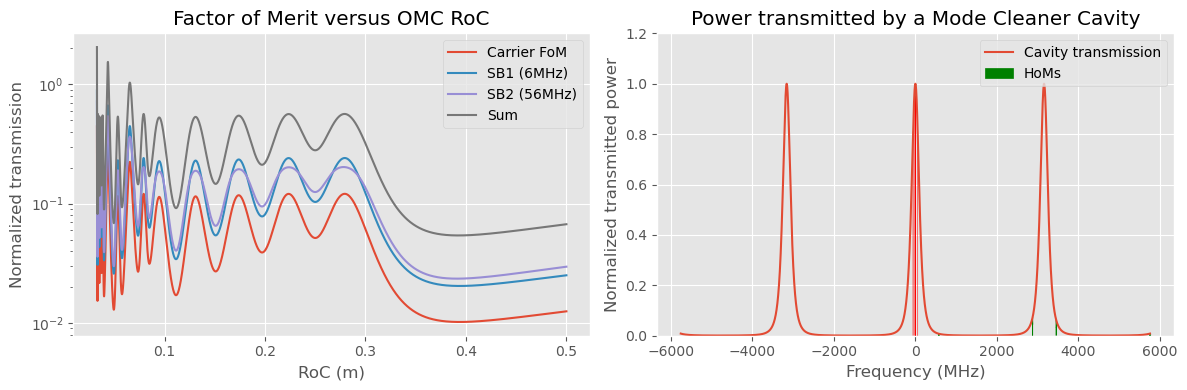

In [12]:
# Constants
cavity_dim=[[0.06200/4],[15e-3]] # Fixed lengths & width of the cavity
P_HoMs = [np.ones(10), np.full(10, 2), np.full(10, 2)]  # Input power of carrier & SBs HOMs


Lgeo=MCdf.Lgeo_cavity(cavity_dim[0][0], cavity_dim[1][0]) # Compute the geometric length of the cavity
Mirror_angle=MCdf.mirror_angle(cavity_dim[0][0], cavity_dim[1][0]) # Compute the mirrors angle in radian
    
Lopt = 2 * idxn * Lgeo
FLopt_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit)) # Determine the max finesse that respect SB_limit
Fomc=FLopt_max / Lopt
    
rho_vect, FoM_vect_car, FoM_vect_SB = MCdf.FoMvsRoC(Lgeo, Fomc, 0.5, fm, P_HoMs) # Compute the best RoC
FoM_vect_sum = FoM_vect_car + FoM_vect_SB[0] + FoM_vect_SB[1]

# Extract the corresponding rho_vect and FoM_vect_sum values
indices = np.where((rho_vect >= 0.1) & (rho_vect <= 0.2))
rho_vect_filtered = rho_vect[indices]
FoM_vect_sum_filtered = FoM_vect_sum[indices]
min_index_filtered = np.argmin(FoM_vect_sum_filtered) # Find the index of the minimum FoM in the filtered FoM_vect_sum
Ideal_RoC = rho_vect_filtered[min_index_filtered] # Get the corresponding rho value from the filtered rho_vect
FoM = FoM_vect_sum_filtered[min_index_filtered] # Get the minimum FoM from the filtered FoM_vect_sum

astigmatism_losses=MCdf.astigmatism_losses(Mirror_angle, Ideal_RoC, Lgeo) * 1e6 # Calculate astigmatism losses

print("Cavity length (cm)=", cavity_dim[0][0]*1e2)
print("Finesse=", Fomc)
print("RoC (cm)=", Ideal_RoC*1e2, ", FoM=", FoM)
print("Mirror angle (°)=", np.rad2deg(Mirror_angle), ", losses (ppm)=", astigmatism_losses)
print()

waist = MCdf.waist_size(Lgeo, Ideal_RoC, lambda_)
print("Waist size (μm):", waist*1e6)

P_input = 1.0  # Input power in Watts
max_pwr = MCdf.circ_power(P_input, waist)
print("Circ power (MW/m²):", max_pwr/1e6)

g=(1-(Lgeo*2)/Ideal_RoC)

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(rho_vect, FoM_vect_car, label='Carrier FoM')
ax1.plot(rho_vect, FoM_vect_SB[0], label='SB1 (6MHz)')
ax1.plot(rho_vect, FoM_vect_SB[1], label='SB2 (56MHz)')
ax1.plot(rho_vect, FoM_vect_sum, label='Sum')
ax1.set_xlabel('RoC (m)')
ax1.set_ylabel('Normalized transmission')
ax1.set_yscale('log')
ax1.set_title('Factor of Merit versus OMC RoC')
ax1.legend()


MCdf.plot_transmission(Lgeo, Fomc, Ideal_RoC, fm, 10, ax2)

# Display the subplots
plt.tight_layout()
plt.show()
